In [1]:
import mpmath as mpm
import numpy as np
def Chbshv_poly(L, x): # Lth Chebyshev polynomial of the first kind
    return mpm.cos(L * mpm.acos(x))
    
def Hn(n):
    # Hadamard Gate H^{\otimes n}
    # Return the numpy array
    H = 1/np.sqrt(2) * np.array([[1,1],[1,-1]])
    Hn = H*1
    for i in range(n-1):
        Hn = np.kron(Hn, H)
    return Hn


def In(n):
    # 2-by-2 Identity gate I^{\otimes n}
    # Reutrn the numpy array
    I = np.array([[1,0],[0,1]])
    In = I*1
    for i in range(n-1):
        In = np.kron(In, I)
    return In

def checkUnitary(A):
    # Check if a given matrix A is unitary
    # Return
    nrow = A.shape[0]
    return np.linalg.norm(A.dot(A.conj().T) - In(int(np.log2(nrow))))

In [2]:
# Input parameters for the Fixed-Point Grover's search
n = 2 # Number of qubits 
indices_to_mark = 2 # An interger from 0 to 2**n

itr = 1 # Number of iterations
d = mpm.sqrt(0.2) # Success probability P_L >= 1 - d^2 if lambda = len(indices_to_mark)/2**n >= omega

In [3]:
# Compute the rest of parameters
l = itr
L = 2*l+1

gamma_inverse = Chbshv_poly(1/L, 1/d)
omega = 1 - Chbshv_poly(1/L, 1/d)**(-2)

alpha =  mpm.zeros(1,l)
beta = mpm.zeros(1,l)
for i in range(l): # use i instead of j since python use 1j for sqrt(-1)
    alpha[i] = 2*mpm.acot(mpm.tan(2*mpm.pi*(i+1)/L) * mpm.sqrt(1-1/gamma_inverse**2))
    beta[l-(i+1)+1-1] = -alpha[i]
    
# Convert to numpy
gamma_inverse = np.array([gamma_inverse], dtype=complex)[0]
omega = np.array([omega], dtype=complex)[0]
alpha = np.array(alpha.tolist()[0], dtype=complex)
beta = np.array(beta.tolist()[0], dtype=complex)

print("gamma^-1 = ", gamma_inverse)
print("lambda = ", 1/2**n)
print("Omega = ", omega)
print("alpha", alpha)
print("beta", beta)

gamma^-1 =  (1.118033988749895+0j)
lambda =  0.25
Omega =  (0.20000000000000007+0j)
alpha [-1.82347658+0.j]
beta [1.82347658+0.j]


In [4]:
# Simulate the computation process
# Start with |0...0> as default to many quantum computing platforms
ket0 = np.zeros((2**n, 1))
ket0[0] = 1

# Initilize the state with matrix A, where |s> = A|0...0>
A = Hn(n) # Use H^{\otimes n} to initilize the state
kets = np.dot(A, ket0) #Compute |s>

# Compute |t>, the target state
kett = np.zeros((2**n, 1))
kett[indices_to_mark] = 1 

# State Grover iterations
starting_state = kets
for i in range(itr):
    a = alpha[i] # selected alpha
    b = beta[i] # selected beta
    
    # Construct S_t(beta)
    Sbeta = In(n) - (1-np.exp(1j*b))*np.dot(kett,kett.T)
    if checkUnitary(Sbeta) > 1e-8:
        print("Potential non-unitary S_beta at itr {:d}, norm of difference is {:.4g}".format(i, checkUnitary(Sbeta)))
    # Construct S_s(alpha)
    Salpha = In(n) - (1-np.exp(-1j*a))*np.dot(kets,kets.T)
    if checkUnitary(Salpha) > 1e-8:
        print("Potential non-unitary S_alpha at itr {:d}, norm of difference is {:.4g}".format(i, checkUnitary(Salpha)))

    starting_state = np.dot(Salpha, np.dot(Sbeta, starting_state))
    
sol = starting_state*1 # Final output state
print("The probability of measuring each basis (from |0...0> to |1...1>):\n", np.abs(sol)**2)
print("The probability of measuring target basis {:.3g}".format((np.abs(sol)**2)[indices_to_mark][0]))

The probability of measuring each basis (from |0...0> to |1...1>):
 [[0.03515625]
 [0.03515625]
 [0.89453125]
 [0.03515625]]
The probability of measuring target basis 0.895


In [5]:
from qiskit.quantum_info import Operator
from qiskit import QuantumCircuit
from qiskit import Aer,execute, QuantumRegister, transpile
from qiskit.visualization import plot_histogram

qc = QuantumCircuit(n, n)
for i in range(n):
    qc.h(i)
for i in range(itr):
    a = alpha[i] # selected alpha
    b = beta[i] # selected beta

    Sbeta = In(n) - (1-np.exp(1j*b))*np.dot(kett,kett.T)
    qc.unitary(Operator(Sbeta), range(n))
    Salpha = In(n) - (1-np.exp(-1j*a))*np.dot(kets,kets.T)
    qc.unitary(Operator(Salpha), range(n))

qc.measure(range(n), range(n))
qc.draw(output='text')

┌───┐┌──────────┐┌──────────┐┌─┐   
q_0: ┤ H ├┤0         ├┤0         ├┤M├───
     ├───┤│  unitary ││  unitary │└╥┘┌─┐
q_1: ┤ H ├┤1         ├┤1         ├─╫─┤M├
     └───┘└──────────┘└──────────┘ ║ └╥┘
c: 2/══════════════════════════════╩══╩═
                                   0  1

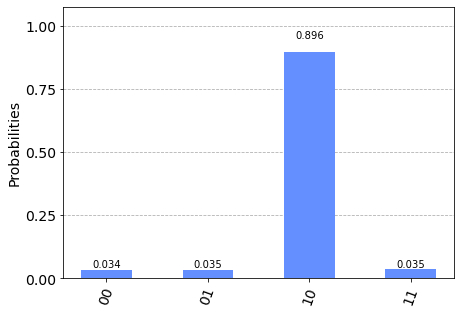

In [6]:
simulator = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend=simulator, shots=10000).result().get_counts()
plot_histogram(counts)

In [7]:
# Load IBMQ Account and choose a real backend
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
name = 'ibmq_belem'
backend = provider.get_backend(name)

In [8]:
# Transile the circuit to see what the actual circuit that can run on the real device
circ_trans = transpile(qc, backend, optimization_level=1) # Optimization level from 0 to 3, short circuit depth
print("Circuit Depth is {:d}".format(circ_trans.depth()))
job = execute(circ_trans, backend=backend, shots=8192, optimization_level=0)
job_monitor(job)

Circuit Depth is 22
Job Status: job has successfully run


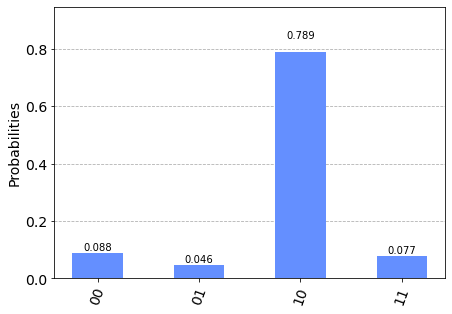

In [9]:
real_counts = job.result().get_counts()
plot_histogram(real_counts)